# XAI - TP1: Interpreting Model Predictions using SHAP
### Anne Gagneux


**Topic**: SHAP stands for SHapley Additive exPlanations. The goal of SHAP is to assign to each feature an importance value for a particular prediction. SHAP views the explanation of a model's predictions as a model itself. The underlying idea is that for a simple model, the model is interpretable by nature. For instance, with a linear model, the larger the coefficient for one feature is, the more important this feature is to the prediction.

So to understant a complex mode, the idea is to use as an explanation a simpler model that gives the same predictions as the complex one.

**Method**
Let $f$ be the original prediction model to be explained and $g$ the explanation model.

$$g(z) = \phi_0 + \sum_{i=1}^M \phi_i z_i$$
Where $z \in \{0,1\}^M$ is a binary variable and $M$ is the number of input features.

**Shapley values**  Let's say we want to compute the importance of a feature $i$. We consider all feature subsets $S \subset F$ (where $F$ is the set of all features). Two models are trained: one with that feature present $f_{S\cup \{i\}}$ and a model $f_S$ without the feature. Then, the predictions of the two models are compared:
$$ f_{S\cup \{i\}}(x_{S\cup \{i\}}) - f_{S}(x_{S}) $$

Shapley values are then computed by averaging for all possible subsets not containing the studied feature $i$:
$$\phi_i = \sum_{S \subset F ∖ \{i\}} \frac{|S|!(|F|-|S|-1)!}{|F|!} \left( f_{S\cup \{i\}}(x_{S\cup \{i\}}) - f_{S}(x_{S}) \right)$$

Here, our binary variable for $z$ in $g(z)$ is computed as $x = h_x(z)$ where we set to $0$ the coefficients that are not included in the model.

### In practice:

All possible coalitions (sets) of feature values have to be evaluated with and without the $i$-th feature to calculate the exact Shapley value: it quickly becomes untracktable. To avoid this problem, we can approximate Shapley values doing Monte Carlo:

$$\hat \phi_i = \frac{1}{N} \sum_{i=1}^N \left(f(x_{+j}^m) - f(x^m_{-j}) \right)$$

  where $x_{+j}^m$ has a random number of feature values replaced by random data, except for the feature $i$ and  $x^m_{-j}$ is equal to $x_{+j}^m$ except for the $i$-th component which is also random.



## First studycase: the Adult Census Income dataset

Predict whether income exceeds $50K/yr based on census data.

In [2]:
import sklearn

In [3]:
#Run if shap not installed
! pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 3.2 MB/s eta 0:00:00


In [4]:
import shap

In [5]:
from sklearn import model_selection

In [6]:
# a classic housing price dataset
X, y = shap.datasets.adult(n_points=2000)
X_display, y_display = shap.datasets.adult(n_points=2000, display=True)

In [7]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size=0.1,
                                                                    random_state=80)

First, let's inspect the data.

In [8]:
X_display.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 22278 to 32524
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Age             2000 non-null   float32 
 1   Workclass       2000 non-null   category
 2   Education-Num   2000 non-null   float32 
 3   Marital Status  2000 non-null   category
 4   Occupation      2000 non-null   category
 5   Relationship    2000 non-null   category
 6   Race            2000 non-null   category
 7   Sex             2000 non-null   category
 8   Capital Gain    2000 non-null   float32 
 9   Capital Loss    2000 non-null   float32 
 10  Hours per week  2000 non-null   float32 
 11  Country         2000 non-null   category
dtypes: category(7), float32(5)
memory usage: 71.6 KB


In [9]:
X_display.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
22278,27.0,Private,10.0,Divorced,Adm-clerical,Unmarried,White,Female,0.0,0.0,44.0,United-States
8950,27.0,Private,13.0,Never-married,Prof-specialty,Not-in-family,White,Female,0.0,0.0,40.0,United-States
7838,25.0,Private,12.0,Married-civ-spouse,Sales,Husband,White,Male,0.0,0.0,40.0,United-States
16505,46.0,Private,3.0,Married-civ-spouse,Transport-moving,Husband,Amer-Indian-Eskimo,Male,0.0,1902.0,40.0,United-States
19140,45.0,Private,7.0,Divorced,Transport-moving,Not-in-family,White,Male,0.0,2824.0,76.0,United-States


### Let's start simple: logistic regression


$$p_{\mathbf{\theta}}(y=1|\mathbf{x}) = \frac{1}{1+\exp(-\mathbf{\theta^\top x})}$$

$$p_{\mathbf{\theta}}(y=0|\mathbf{x}) = \frac{\exp(-\mathbf{\theta^\top x})}{1+\exp(-\mathbf{\theta^\top x})}$$

To compute the optimal parameters $\mathbf{\theta^*}$ of our model, we minimize the negative log likelihood.

$$\mathbf{\theta^*} = {\arg \min}_{\mathbf{\theta}} J(\mathbf{\theta})$$

with the loss $ J(\mathbf{\theta}) $ defined as follows:

\begin{align} J(\mathbf{\theta}) & = - \log \prod_{i=1}^N p_{\mathbf{\theta}}(y^{i}|\mathbf{x}^{i}) \\ &= - \sum_{i=1}^N y^{i} \log p_{\mathbf{\theta}}(y=1|\mathbf{x^i}) + (1-y^i) \log p_{\mathbf{\theta}}(y=0|\mathbf{x^i})
\end{align}

In [10]:
# a simple linear model
model = sklearn.linear_model.LogisticRegression()
model.fit(x_train, y_train)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression()

In [11]:
y_pred = model.predict(x_test) # make the prediction

In [12]:
((y_pred == y_test)).mean() # compute the accuracy of our model

0.81

In [13]:
def model_adult_proba(x):
    return model.predict_proba(x)[:, 1]

In [14]:
print("Model coefficients:\n")
for i in range(X.shape[1]):
    print(X.columns[i], "=", model.coef_[0,i].round(5))

Model coefficients:

Age = -0.0045
Workclass = -0.16633
Education-Num = 0.16213
Marital Status = -0.41191
Occupation = -0.01382
Relationship = 0.46157
Race = -0.11404
Sex = 0.06068
Capital Gain = 0.00034
Capital Loss = 0.00071
Hours per week = 0.0023
Country = -0.0568


**Remark**: Because the values of the features are not normalized, the coefficients themselves don't tell much. A change of $1$ for the number of hours per week does not have the same meaning as a change of $1$ in the marital status.

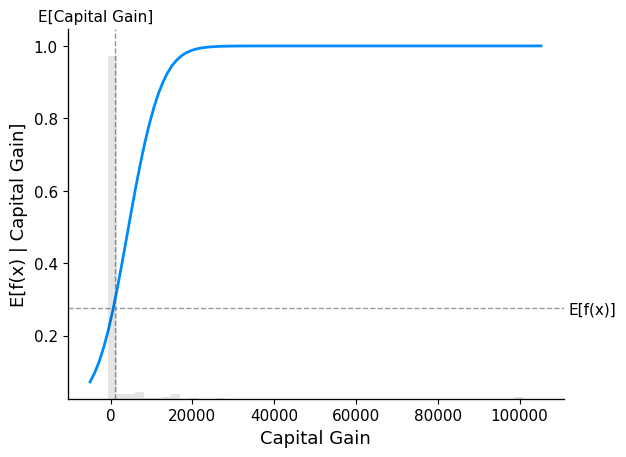

In [22]:
shap.partial_dependence_plot(
    "Capital Gain",
    model_adult_proba,
    X,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

In [23]:
def model_adult_log_odds(x):
    p = model.predict_log_proba(x)
    return p[:, 1] - p[:, 0]

divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log


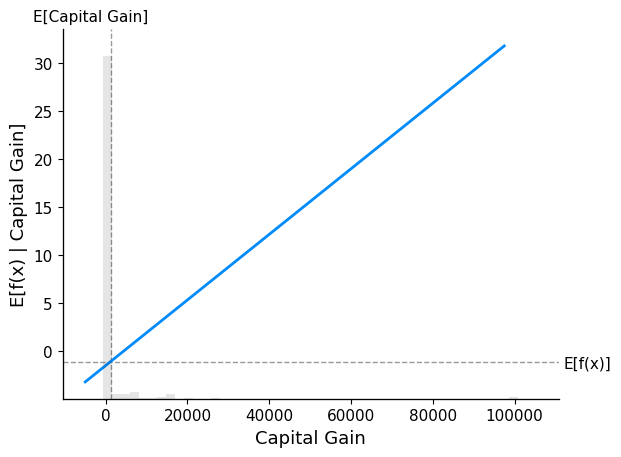

In [24]:
shap.partial_dependence_plot(
    "Capital Gain",
    model_adult_log_odds,
    X,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

**QUESTION**: For the partial dependence plot, what difference do you observe using log-odds instead of probabilities in the model's outputs ? How do you explain it ?

### Now, we train an XGBoost Classifier which is a much more complex model, difficult to interpret.

In [43]:
import xgboost
# train XGBoost model
X,y = shap.datasets.adult()
params_xgb = {
    "n_estimators": 200,
    "max_depth": 8,
    "learning_rate": 0.05,
}
X_display, y_display = shap.datasets.adult(display = True)
model = xgboost.XGBClassifier().fit(X, y)
# compute SHAP values
explainer = shap.TreeExplainer(model, X,  model_output = "raw")
shap_values = explainer(X)

[09:10:05] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
100%|===================| 32480/32561 [01:57<00:00]       

#### Local interpretability: How to explain a single prediction ?

The output of the model is equal to $\log \left(\frac{p ( y=1 | \mathbf{x})}{1-p(y = 1|\mathbf{x})} \right)$, i.e.:

\begin{align}
\log \left(\frac{p ( y=1 | \mathbf{x})}{1-p(y = 1|\mathbf{x})} \right) & > 0\\
\iff \frac{p ( y=1 | \mathbf{x})}{1-p(y = 1|\mathbf{x})} & > 1 \\
\iff p ( y=1 | \mathbf{x}) > 1-p(y = 1|\mathbf{x}) & = p(y = 0|\mathbf{x})
\end{align}

So, positive values of the output mean that the probability that the person has an income greater than 50k dollars / a year is larger than $0.5$.

**Tools**:
- *Force plot*: on a force plot, we observe how each feature increases the probability of having an income greater than $50k/yr (in red) or decreases it (in blue).

- *Waterfall plot*: The bottom of a waterfall plot starts as the expected value of the model output, and then each row shows how the positive (red) or negative (blue) contribution of each feature moves the value from the expected model output over the background dataset to the model output for this prediction.

In [68]:
# choose an individual (a sample)
sample_index = 3


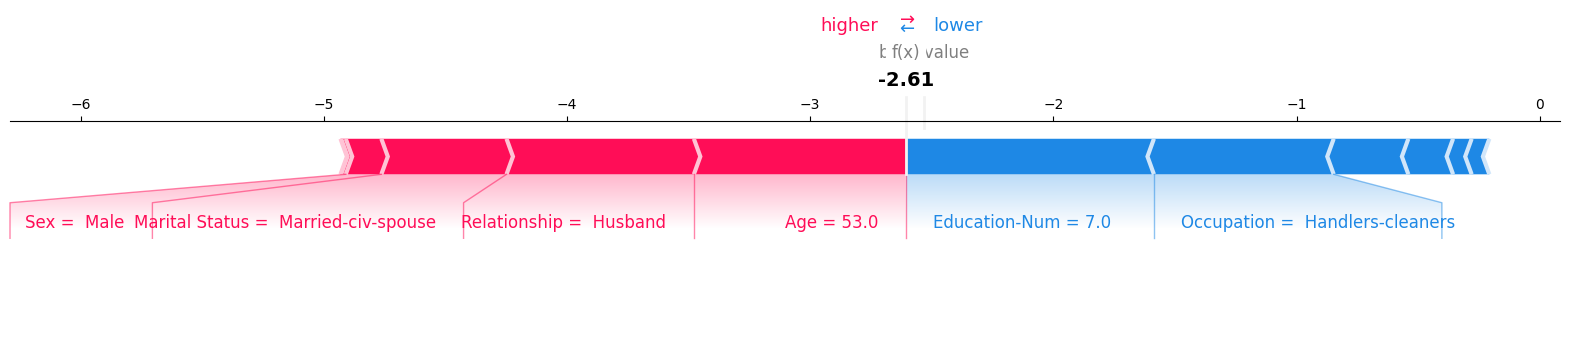

In [69]:
shap.force_plot(explainer.expected_value, shap_values.values[sample_index,:], X_display.iloc[sample_index,:],matplotlib=True )

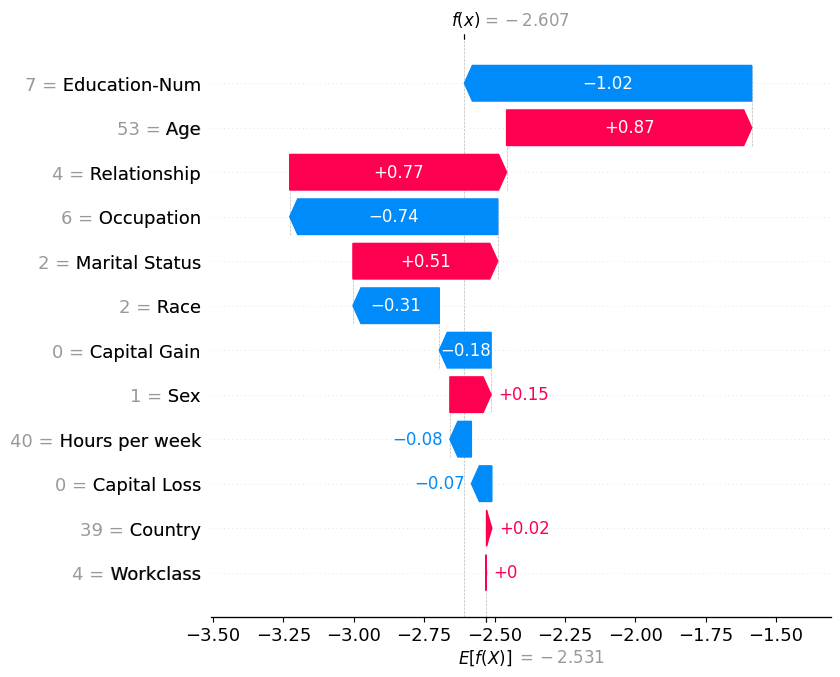

In [70]:
shap.plots.waterfall(shap_values[sample_index], max_display=14)

#### Features interpretability: How to explain a single prediction ?

**Tools**:
- *Scatter plot*: on a scatter plot, we observe how, for one chosen features, its value impacts the Shapley values. The vertical dispersion in the plot above shows that the same value for the feature can have a different impact on the model’s output for different people.


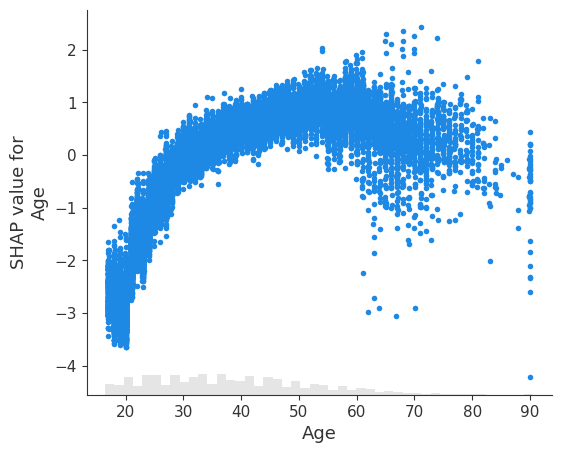

In [71]:
shap.plots.scatter(shap_values[:, "Age"])

To understand, which other feature might explain the vertical dispersion, we can color the scatter plot with another feature.

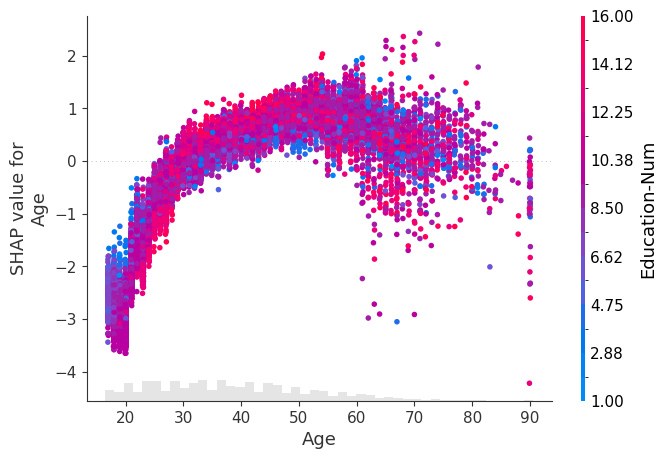

In [74]:
shap_values.display_data = X_display.values
shap.plots.scatter(shap_values[:, "Age"], color=shap_values[:, "Education-Num"])

**QUESTION**: Can you comment on the effect of the interaction between Education-Num and Age ?

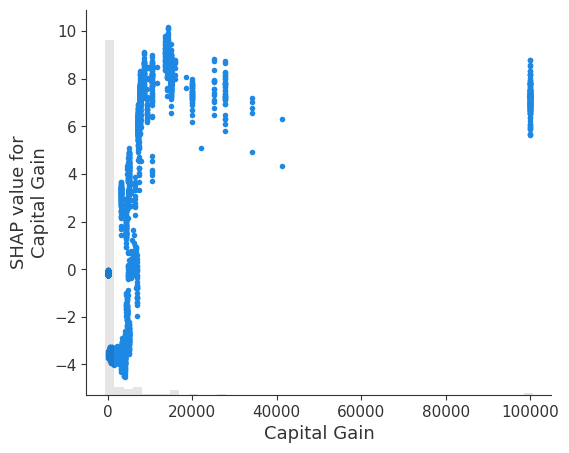

In [77]:
shap.plots.scatter(shap_values[:, "Capital Gain"])

**QUESTION**: How can you interpret the impact of Capital Gain ?

#### Global interpretibility

**Tools**:
- *Summary plot*: The SHAP summary plot allows us to understand the model by ranking the features from the most relevant to the least important ones. Each datapoint represents a different person.

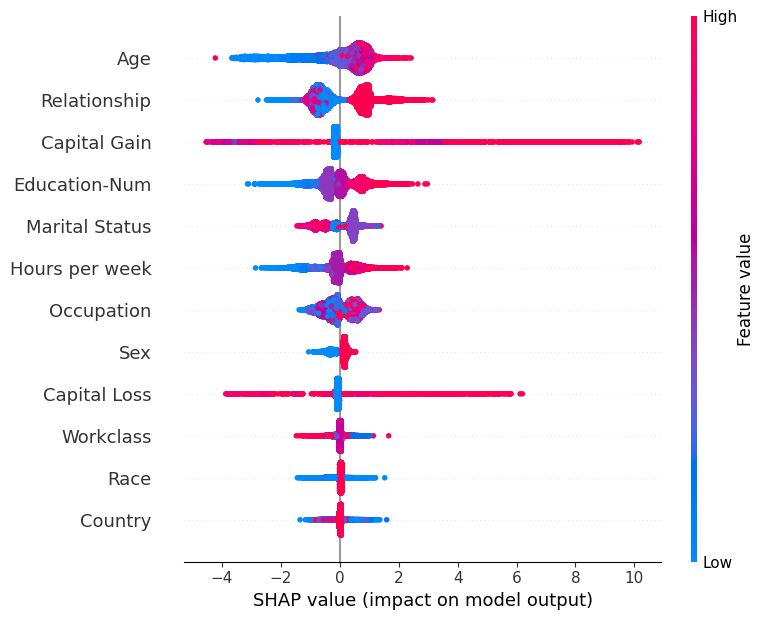

In [76]:
shap.summary_plot(shap_values, X)
